## NLP Project  - Surendiran Rangaraj
**Date : 12/1/2021**


Illinois is famous for being one of the very few states in the country with negative population growth.  The objective of your final project is to:

    1. Identify the key reasons for the declining population (what people like / dislike about Chicago / suburbs) by extracting meaningful insights from unstructured text
    2. Provide actionable recommendations on what can be done to reverse this trend (how to make Chicago / suburbs more attractive)
    
You have access to a collection of ~200K news articles (about 500 MB).  The news articles are related to either Chicago and / or Illinois and you can access them in the following ways:

    . Download a data by following this think from your browser: https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.jsonLinks to an external site.
    . Use Spark on GCP news_final_project = spark.read.parquet('gs://msca-bdp-data-open/news_final_project')
    . Use Pandas from anywhere (your laptop, Colab or any cloud) df_news_final_project = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', orient='records', lines=True) 
 

To complete your assignment, I suggest considering the following steps:

    . Clean-up the noise (eliminate articles irrelevant to the analysis)
    . Detect major topics
    . Identify top reasons for population decline (negative sentiment)
        . Suggest corrective actions
        . Plot a timeline to illustrate how the sentiment is changing over time
    . Demonstrate how the city / state can attract new businesses (positive sentiment)
    . Leverage appropriate NLP techniques to identify organizations and people and apply targeted sentiment
        . Why businesses should stay in IL or move into IL?
            . Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
        . Why residents should stay in IL or move into IL?
            . Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)

**Additional guidance:**

    . Default sentiment will likely be wrong from any software package and will require significant tweaking
        . Either keyword / dictionary approach or
        . Labeling and classification
        
    . You are encouraged to explore a combination several techniques to identify key topics:
        . Topic modeling (i.e. LDA using gensim or ktrain)
        . Classification (hand-label several topics on a sample and then train classifier)
        . Clustering (cluster topics around pre-selected keywords or word vectors)
        . Zero-shot (NLI) modeling
        . Please ensure your PowerPoint presentation (in PPTX or PDF format) is submitted to the course module as-is (not zipped). Otherwise I am unable to use Canvas SpeedGrader.
        . The presentation should look professional – not a collection of screenshots from your analytical software
        . Roughly 8-12 pages is reasonable for this kind of project but there are no strict restrictions.
        . On your slides you will want to provide:
            . Executive Summary
            . Methodology and source data overview
            . Actionable recommendations
            . Apply text summarization algorithms where possible to synthesize your insights
        . Please submit your actual program codes (Jupyter notebooks) along with your PowerPoint
        . The slides should be self-sufficient and after reading them, there should not be any need to read the notebook (we are still asking you to provide the notebooks as a proof or work though).
        . The slides should clearly answer all the questions and the answers should be supported with the plots/tables/numbers produced in the notebook based on the actual data.
        . The slides should contain the RIGHT amount of supporting material for each question, putting too much supporting material is as bad as putting too little: too much - you would not be able to keep the audience attention and your presentation would be a mess, too little - your statements would not look convincing.
        . Everything should be clear, logical, well organized, as simple as possible.  Use proper English and run spell check.
        . All the plots should be of production quality and easily readable. Foggy plots, untitled plots, unreadable labels, overlapping labels are unacceptable.
        . If you formatting somehow gets corrupted when you put your slides into Canvas (sometimes it happens), it is your responsibility to fix formatting. For example, try saving it in some other format like PDF, HTML.
        . Any statements you make should be supported by data. Only recommendations or goals of the project sections can contain elements not directly supported by the data
        . Please submit your actual program codes (i.e. Python Notebook) along with your PowerPoint – as a separate attachment
            . Your presentation should be targeted toward business audience and must not contain any code snippets
    .You are welcome to use any software packages of your choice to complete the assignment

### Import Libraries

In [1]:
!pip install ktrain
!pip install pyLDAvis

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import time
import math
from pprint import pprint
from textblob import TextBlob

import spacy
import multiprocessing
import string
from spacy import displacy
from collections import Counter
print(spacy.__version__)
print('Python Version: ' + sys.version)
print('TensorFlow Version: ' + tf.__version__)

2.2.4
Python Version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow Version: 2.7.0


In [4]:
import bokeh

print('Bokeh Version: ' + bokeh.__version__)

import ktrain
from ktrain import text
print('Ktrain Version: ' + ktrain.__version__)

Bokeh Version: 2.3.3
Ktrain Version: 0.28.3


In [5]:
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore,LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [6]:
pd.set_option('display.max_rows', 500) # Set Max Number of Rows
pd.set_option('display.max_columns', 50) # Set Max Number of Columns
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200) # Set Max Width of Cell
pd.set_option('display.max_info_columns', 200) # Set Max Number of Columns Shown in info()
pd.set_option('display.precision', 6)#Set Display Precision of float values (0.123456)
#pd.options.display.float_format = '{:.2f}%'.format # Set Decimal Format (0.12%)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# the base Google Drive directory
root_dir = "/content/drive/My Drive/"
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP/yelp/"
data_folder = "Colab Notebooks/NLP/yelp/"
model_folder = "Colab Notebooks/NLP/yelp/models"
dataPath = root_dir+data_folder
modelPath = root_dir+model_folder
print("dataPath: " , dataPath)
print("modelPath: " , modelPath)

dataPath:  /content/drive/My Drive/Colab Notebooks/NLP/yelp/
modelPath:  /content/drive/My Drive/Colab Notebooks/NLP/yelp/models


In [9]:
from google.colab import files

### Read Topic Filter Data

In [10]:
filter_topics_df = pd.read_json(dataPath+"news_filtered_Topics_Sentiments.json",orient='records',lines=True) 

In [11]:
len(filter_topics_df)

55018

In [12]:
filter_topics_df.sentiment.value_counts()

Positive    28485
Negative    26533
Name: sentiment, dtype: int64

Filter Positive and Negative Sentiment articles to separate Dataframe

In [13]:
filter_positive_topics_df = filter_topics_df[filter_topics_df.sentiment == "Positive"]
filter_negative_topics_df = filter_topics_df[filter_topics_df.sentiment == "Negative"]
print(len(filter_positive_topics_df),len(filter_negative_topics_df))

28485 26533


In [14]:
positive_text_list = filter_positive_topics_df['text_clean'].tolist()  
negative_text_list = filter_negative_topics_df['text_clean'].tolist()  

In [15]:
#nlp = spacy.load("en_core_web_sm")

### Topic Modeling for Filtered data - Positive Sentiment
#### kTrain
#### Save the Ktrain Topic Models
The get_topic_model function learns a topic model using Latent Dirichlet Allocation (LDA).

In [16]:
load_pretrained = True

In [17]:
%%time
if load_pretrained:
  positive_tm = ktrain.text.load_topic_model(modelPath+'/ktrain/'+'ktrain_news_filtered_positive_topics')
else:
  positive_tm = ktrain.text.get_topic_model(
      texts=positive_text_list, 
      n_topics=20, 
      n_features=10000, 
      min_df=5, 
      max_df=0.9, 
      stop_words='english', 
      model_type='lda', 
      lda_max_iter=5, 
      verbose=1)
  positive_tm.save(modelPath+'/ktrain/'+'ktrain_news_filtered_positive_topics')

done.
CPU times: user 133 ms, sys: 14.7 ms, total: 148 ms
Wall time: 4.38 s


In [18]:
%%time
if load_pretrained:
  negative_tm = ktrain.text.load_topic_model(modelPath+'/ktrain/'+'ktrain_news_filtered_negative_topics')
else:
  negative_tm = ktrain.text.get_topic_model(
      texts=negative_text_list, 
      n_topics=20, 
      n_features=10000, 
      min_df=5, 
      max_df=0.9, 
      stop_words='english', 
      model_type='lda', 
      lda_max_iter=5, 
      verbose=1)
  negative_tm.save(modelPath+'/ktrain/'+'ktrain_news_filtered_negative_topics')

done.
CPU times: user 74.4 ms, sys: 8.04 ms, total: 82.5 ms
Wall time: 2.58 s


### Build the Document-Topic matrix

In [19]:
%%time
negative_tm.build(negative_text_list, threshold=0.05)
positive_tm.build(positive_text_list, threshold=0.05)

done.
done.
CPU times: user 1min 3s, sys: 1min 15s, total: 2min 19s
Wall time: 53 s


The build method may prune documents based on threshold. This method prunes other lists based on how build pruned documents. This is useful to filter lists containing metadata associated with documents for use with visualize_documents. 

In [20]:
negative_text_list = negative_tm.filter(negative_text_list)
positive_text_list = positive_tm.filter(positive_text_list)

### Print and Visualize the Topics

In [21]:
positive_tm.print_topics(show_counts=True,n_words=20)

topic:5 | count:3569 | said like just people time going know dont chicago thats think want really years make way says good day lot
topic:1 | count:3434 | illinois said state health covid19 public county school states students people pritzker new community schools pandemic president coronavirus cases care
topic:10 | count:3165 | work business experience services job team industry data management information including support company development jobs program service technology help clients
topic:18 | count:2094 | chicago park city area water north lake new building center museum river art south street illinois west chicagos downtown naperville
topic:6 | count:2037 | chicago new black city american said year community years world history york event united international way america president national women
topic:12 | count:2013 | chicago www https news com http sports twitter online med new facebook video media visit latest source casino information gaming
topic:4 | count:1810 | time chica

In [22]:
print(positive_tm.get_docs(topic_ids=[5], rank=True)[1]['text'])

Chicago Hard To Say Im SorryEverybody needs a little time away I heard her say from each other Even lovers need a holiday Far away from each other Hold me now Its hard for me to say Im sorry I just want you to stayAfter all that weve been through I will make it up to you I promise to And after all thats been said and done Youre just the part of me I cant let goCouldnt stand to be kept away Just for the day from your body Wouldnt wanna be swept away Far away from the one that I love Hold me now Its hard for me to say Im sorry I just want you to knowHold me now I really want to tell you Im sorry I could never let you goAfter all that weve been through I will make it up to you I promise to And after all thats been said and done Youre just the part of me I cant let goAfter all that weve been through I will make it up to you I promise to Youre gonna be the lucky one                                                                                                                               

In [23]:
negative_tm.print_topics(show_counts=True,n_words=20)

topic:15 | count:3204 | said police chicago man shot shooting hospital people south block taken killed condition woman according car vehicle west dead street
topic:1 | count:2910 | just like dont going time know think chicago people really want way make thats good right got said lot need
topic:0 | count:2884 | said health people covid19 illinois coronavirus state pritzker pandemic public vaccine care order virus new officials department residents states week
topic:18 | count:2529 | illinois state tax said states budget pritzker income house federal taxes lawmakers billion election government vote senate general democrats gov
topic:6 | count:2230 | police chicago said officers city officer lightfoot mayor video department gun shooting people shot brown violence citys lori johnson crime
topic:3 | count:1848 | court attorney case judge federal chicago county lawsuit illinois charges office prison prosecutors law criminal years filed said charged cook
topic:10 | count:1633 | illinois year 

In [24]:
#negative_tm.visualize_documents(doc_topics=negative_tm.get_doctopics())

Top-ranked document for the topic 18 : Change in income tax rate

In [25]:
print(negative_tm.get_docs(topic_ids=[18], rank=True)[0]['text'])

Illinois voters deciding on graduated income tax proposal JOHN OCONNOR , AP Political Writer Nov. 2, 2020 Comments FILE  In this March 7, 2019, file photo, Gov. J.B. Pritzker outlines his plan to replace Illinois flatrate income tax with a graduated structure at the State Capitol in Springfield, Ill. Both sides in the debate over changing Illinois income tax system from a flatrate to a graduated structure, which voters face on this falls election ballot, have straightforward arguments. John OConnorAPSPRINGFIELD, Ill. AP  Illinois would switch from a flat tax to a graduated income tax that takes a larger percentage from wealthy residents under a proposal on Tuesdays ballot.The switch would give Democratic Gov. J.B. Pritzker and lawmakers a roadmap to paying down the states billions of dollars in debt.The question on the ballot would amend the Illinois Constitution, which requires that income be taxed at a flat rate. Its currently at 4.95 for individual payers. Pritzker campaigned on swi

Top-ranked document for the topic 10 : Change in income tax rate

In [26]:
print(negative_tm.get_docs(topic_ids=[10], rank=True)[0]['text'])

Note: This is a composite index of other data.From the Chicago Fed: Index Suggests Slower, but Still Slightly AboveAverage Growth in NovemberLed by slower growth in employment and productionrelated indicators, the Chicago Fed National Activity Index CFNAI declined to 0.27 in November from 1.01 in October. Three of the four broad categories of indicators used to construct the index made positive contributions in November, but all four categories decreased from October. The indexs threemonth moving average, CFNAIMA3, decreased to 0.56 in November from 0.85 in Octoberemphasis added This graph from the Chicago Fed shows the Chicago Fed National Activity Index by category.Click on graph for larger image.According to the Chicago Fed:The index is a weighted average of 85 indicators of growth in national economic activity drawn from four broad categories of data: 1 production and income 2 employment, unemployment, and hours 3 personal consumption and housing and 4 sales, orders, and inventorie

In [27]:
doc_topics = negative_tm.get_doctopics(topic_ids=[10, 18])
negative_tm.visualize_documents(doc_topics=doc_topics)

Output hidden; open in https://colab.research.google.com to view.

Visualize all negative topics

In [28]:
doc_topics = negative_tm.get_doctopics()
negative_tm.visualize_documents(doc_topics=doc_topics)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
doc_topics = positive_tm.get_doctopics()
positive_tm.visualize_documents(doc_topics=doc_topics)

Output hidden; open in https://colab.research.google.com to view.

### Text Summarization

In [30]:
filter_negative_topics_df['text_clean'].iloc[0]

'Facing steep budget deficits and escalating income inequality, Mayor Lori Lightfoot should consider a graduated payroll tax and other ways to make corporations pay their fair share. By Subscribe to Perspectives: The Powers That Be File photo by Marc MonaghanRight now it looks pretty unlikely that the federal government is going to step up with the kind of financial relief that states and cities need in the face of our combined health and economic crisis  perhaps until a new administration is installed next year. And even then, it will take weeks and months to arrive at the local levels where it is so desperately needed.For the city of Chicago, that means a budget deficit this year of at least 700 million, according to city estimates. And it means next years city budget, which must be approved by the City Council this fall, is likely to face a preliminary deficit of 1 billion, according to independent policy analyst Robert Ginsburg, director of the Center on Work and Community Developm

In [31]:
%time 
from ktrain import text
ts = text.TransformerSummarizer()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [32]:
text_to_summarize = filter_negative_topics_df['text_clean'].iloc[0]
ts.summarize(text_to_summarize)

'Facing steep budget deficits and escalating income inequality, Mayor Lori Lightfoot should consider a graduated payroll tax and other ways to make corporations pay their fair share. For companies big enough to qualify, the tax would not be onerous, said Robert Ginsburg. Ginsburg suggests a tiered business payroll tax on companies with payrolls over 7 million, applied to salaries over 150,000.'

In [33]:
filter_positive_topics_df['text_clean'].iloc[2]

'University of Chicago Medicine has received a 10 million gift from a Chicagoarea investor to fund research for cellular therapy used to fight certain types of cancer.David Jonas, CEO of JVC Investment Partners, a firm that invests in early stage and middlemarket health care companies, is funding the research, which will take place at what will now be name the David and Etta Jonas Center for Cellular Therapy, after Jonas and his late wife.A former Baxter International executive, Jonas founded Lake Forestbased PharMEDium Healthcare Corp. in 2003, which provides compounded sterile preparations to hospitals, and sold it to AmerisourceBergen for 2.58 billion in 2015.Jonas said he was impressed with the universitys oncology program and learned of its cellular therapy work from Dr. Michael Bishop, a U Chicago professor of medicine.Through my career I have been involved in supporting research in cellular therapy and believe that chemotherapy alone will never eradicate the last cancer cell. I 

In [34]:
text_to_summarize = filter_positive_topics_df['text_clean'].iloc[2]
ts.summarize(text_to_summarize)

'David Jonas, CEO of JVC Investment Partners, is funding the research, which will take place at what will now be name the David and Etta Jonas Center for Cellular Therapy. Jonas founded Lake Forestbased PharMEDium Healthcare Corp. in 2003 and sold it to AmerisourceBergen for 2.58 billion in 2015.'

### Sentiment Analysis Over Time

In [35]:
sentimentAnalyzerDF = filter_topics_df[['date','neg_prob']]
sentimentAnalyzerDF.sort_values('date',inplace=True)
sentimentAnalyzerDF.reset_index(inplace=True,drop=True)
sentimentAnalyzerDF1 = sentimentAnalyzerDF.groupby(['date'],as_index=False)[['neg_prob']].mean()
sentimentAnalyzerDF1.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


date  neg_prob
0 2018-01-22  0.436790
1 2018-01-23  0.454689
2 2018-01-24  0.453455
3 2018-01-25  0.487302
4 2018-01-26  0.501504

In [36]:
def sentiment_keyword_plt(df,text,size,Title):
  search_text = (text)
  illinois_relevant_df = df[df['text_clean'].str.contains(search_text, case=False, na=False)]
  sentimentAnalyzerDF = illinois_relevant_df[['date','neg_prob']]
  sentimentAnalyzerDF.sort_values('date',inplace=True)
  sentimentAnalyzerDF.reset_index(inplace=True,drop=True)
  sentimentAnalyzerDF = sentimentAnalyzerDF.groupby(['date'],as_index=False)[['neg_prob']].mean()
  plt.style.use('ggplot')
  plt.figure().set_size_inches(size)
  sns_plt = sns.lineplot(data = sentimentAnalyzerDF)
  #Drawing a horizontal line at point 1.25
  sns_plt.axhline(0.5,ls='--',color="blue")
  plt.title(Title)
  plt.xlabel('Index')
  plt.ylabel('Negative Sentiment Probability')
  plt.show()


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


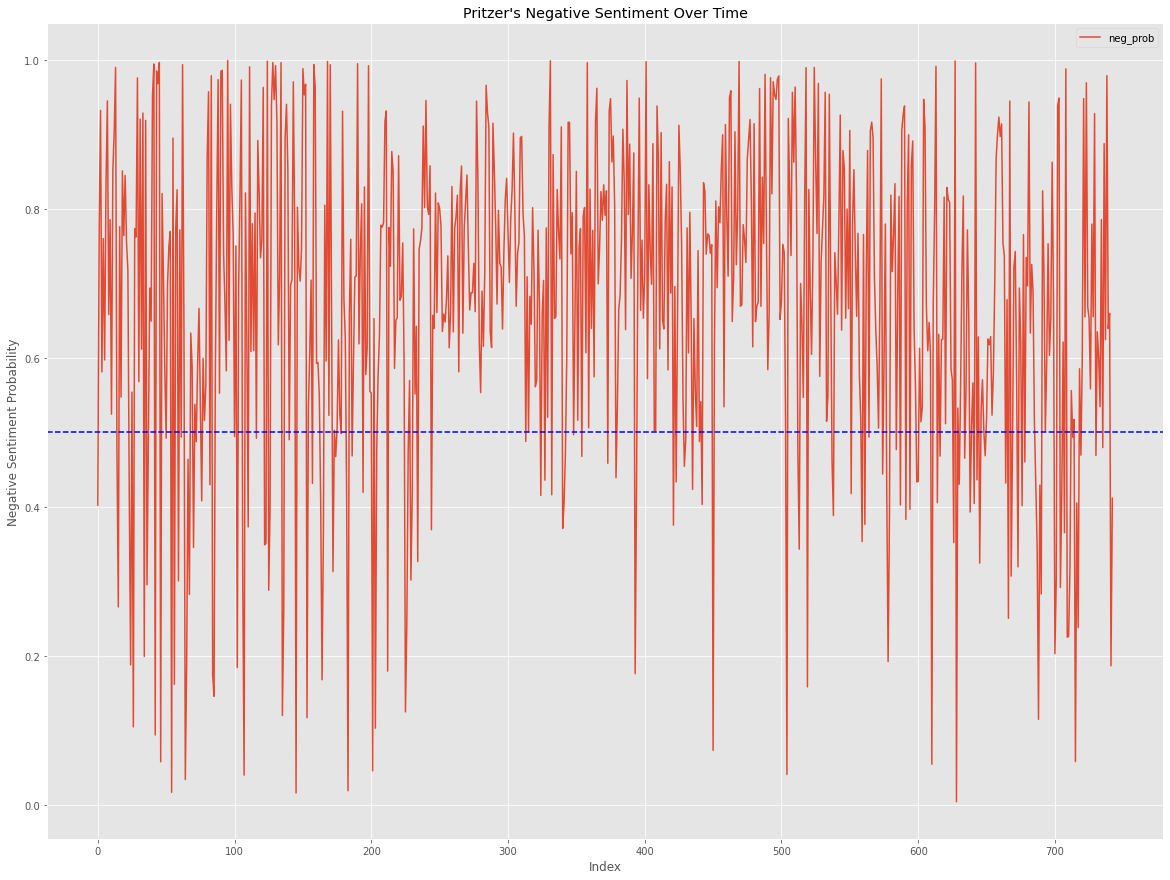

In [37]:
sentiment_keyword_plt(filter_topics_df,"Pritzker",(20,15),"Pritzer's Negative Sentiment Over Time")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


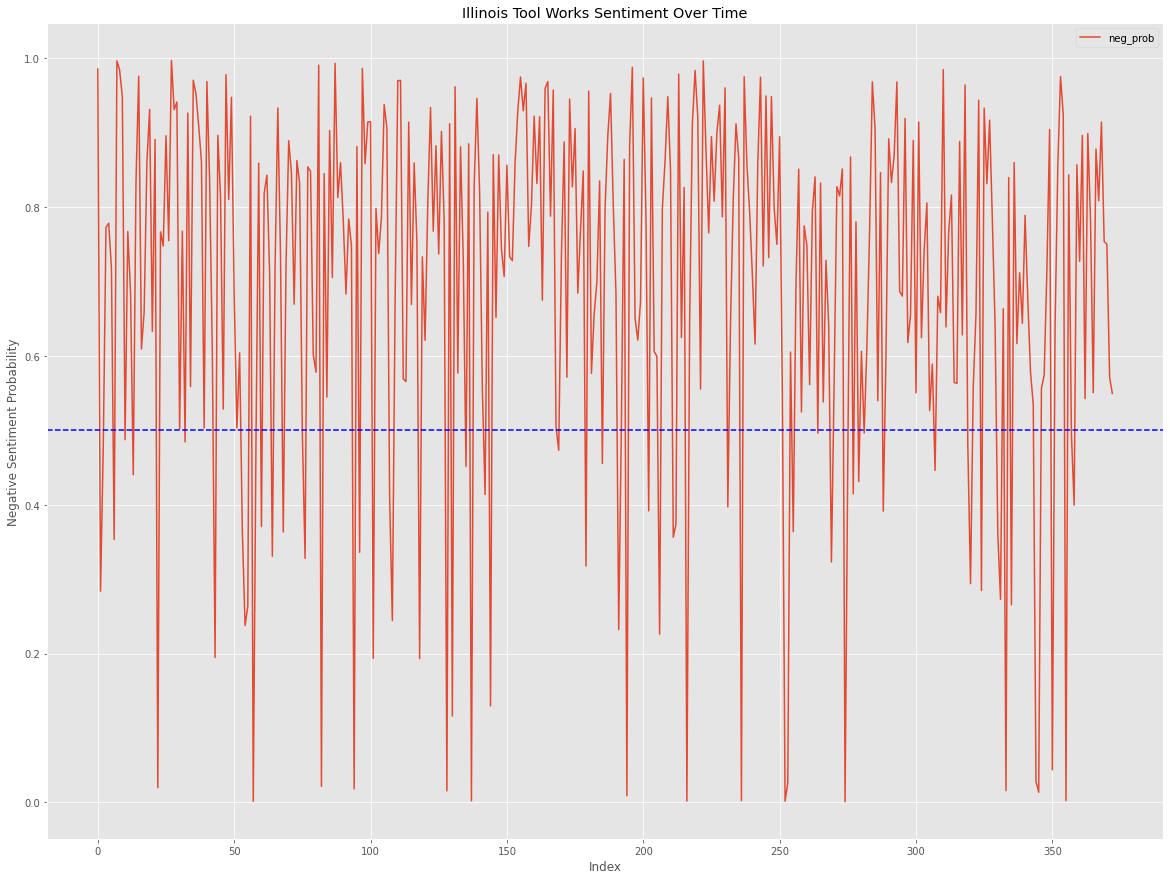

In [38]:
sentiment_keyword_plt(filter_topics_df,"Illinois Tool Works",(20,15),"Illinois Tool Works Sentiment Over Time")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


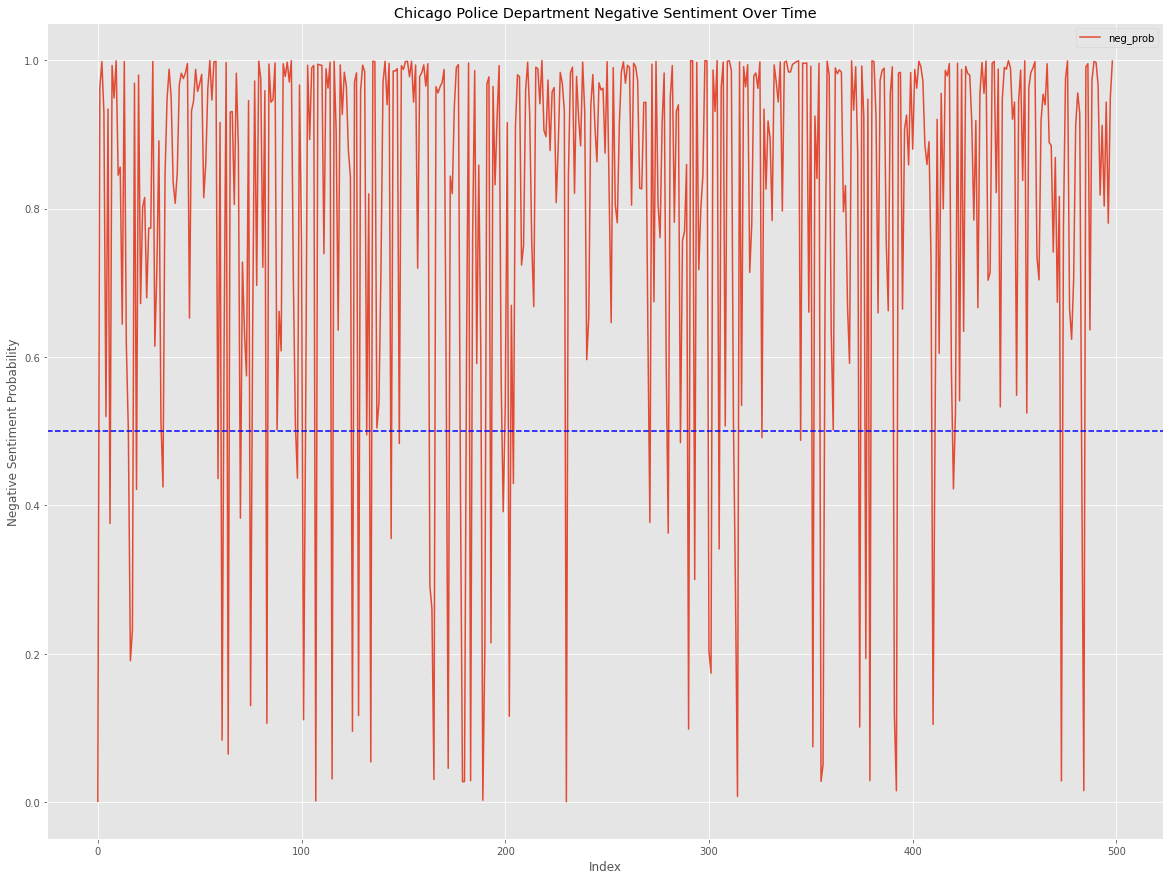

In [39]:
sentiment_keyword_plt(filter_topics_df,"Chicago Police Department",(20,15),"Chicago Police Department Negative Sentiment Over Time")

###  Visualization to summarize the articles 

In [40]:
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer

def display_wordcloud(vect):
  wordcloud_obj = wordcloud.WordCloud(
      width = 1000,
      height = 500,
      background_color = 'white',
      max_words=300,
      stopwords = wordcloud.STOPWORDS)

  wordcloud_obj.generate_from_frequencies(vect)

  fig = plt.figure(
      figsize = (20, 10),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud_obj, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

In [74]:
def tfidf_vectordf(df,lst=False):
  vect = TfidfVectorizer(stop_words='english',lowercase=False,ngram_range=(1, 3),max_df=0.8,min_df = 0.1)
  print("Using TFIDF Vectorizer")
  # combine fit and transform into a single step
  if lst:
    text_tfvect = vect.fit_transform(df)
  else:
    text_tfvect = vect.fit_transform(df.text_clean)
  feature_names = vect.get_feature_names()
  dense = text_tfvect.todense()
  lst = dense.tolist()
  out_df = pd.DataFrame(lst, columns=feature_names)
  vect_freq_series = out_df.T.sum(axis=1)
  return vect_freq_series

In [42]:
filter_negative_topics_df.iloc[0]

index                                                                                                                                                                                                                       6
Unnamed: 0                                                                                                                                                                                                                  6
date                                                                                                                                                                                                      2020-08-07 00:00:00
language                                                                                                                                                                                                              english
title                                                                                                           

In [43]:
#vect_freq = tfidf_vectordf(filter_topics_df)
neg_vect_freq = tfidf_vectordf(filter_negative_topics_df)
pos_vect_freq = tfidf_vectordf(filter_positive_topics_df)

Using TFIDF Vectorizer
Using TFIDF Vectorizer


In [44]:
neg_remove_label = ['The', 'Chicago','said','Illinois','000','new','2020','In','This','just','says','We','according','Monday','He','like','10','It','Friday','week','use','Thursday','Tuesday','But','say','2021','2019',"Wednesday",'make','days','used','All','12','2018','20','11','If','They','people','And','By','20','dont','May','30','did','15','July','April','13','14','16','On','As','25','50','100','17','18','state','city','County','states','news','year']

In [45]:
neg_vect_freq_fplt = neg_vect_freq.drop(labels=neg_remove_label)

In [46]:
neg_vect_freq_fplt.sort_values(ascending =False).head(100)

police         1624.558252
COVID19         902.227723
time            897.124771
shot            833.247732
Police          832.354124
tax             799.767108
information     794.772225
cases           756.290147
man             745.160070
shooting        738.838875
years           721.503454
reported        688.423608
officers        687.941845
Department      683.269962
federal         670.347588
home            665.804589
report          661.404273
Pritzker        654.607823
officials       651.952663
million         651.224563
public          650.484586
Lightfoot       628.331507
State           628.119146
health          621.721391
day             601.664282
including       594.400074
data            578.153910
average         574.779671
News            571.877429
officer         569.764154
coronavirus     567.620610
law             548.539593
told            548.032833
AP              545.237975
going           541.881915
know            532.808824
need            529.123198
w

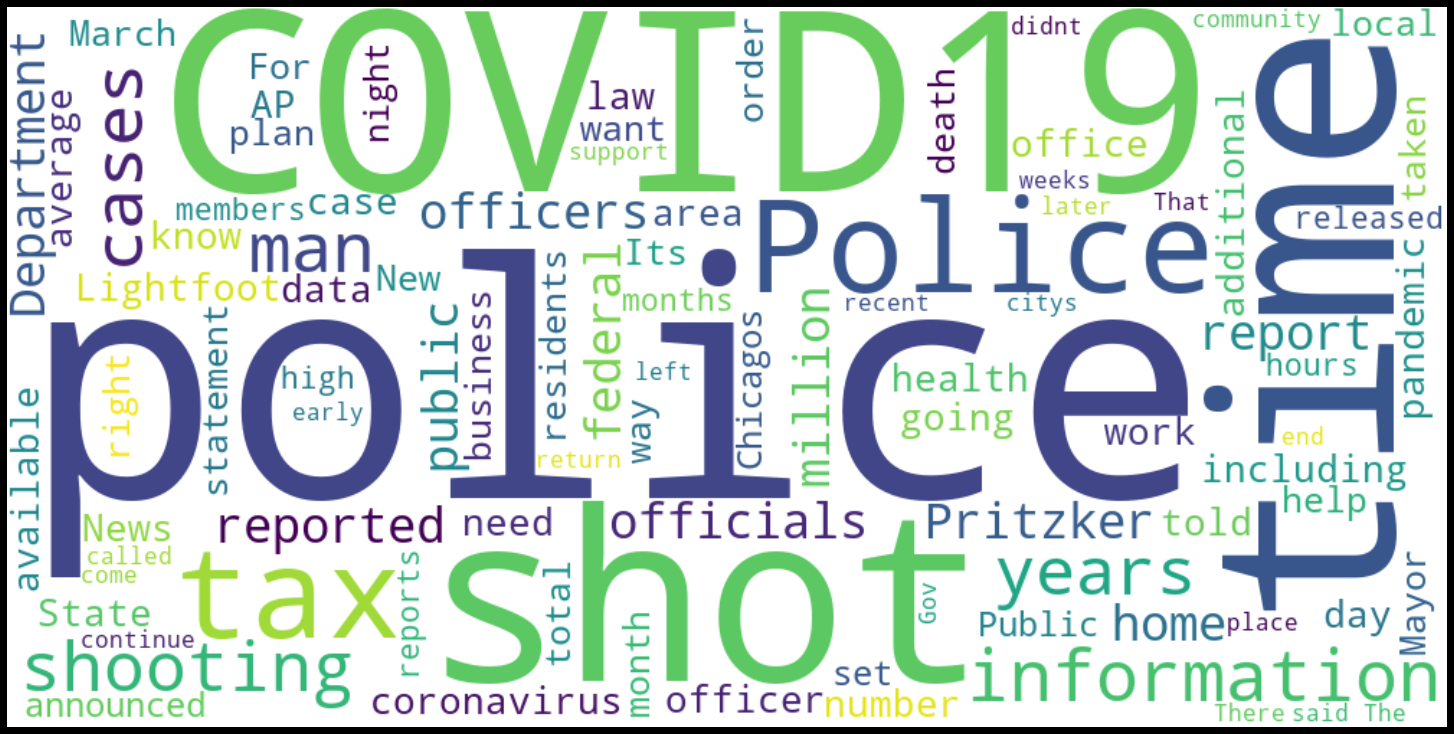

In [47]:
display_wordcloud(neg_vect_freq_fplt)

In [48]:
pos_remove_label = ['You','For','www','To','com','services','need','years','people','New','day','way','Its','area','Our','When','The', 'Chicago','said','Illinois','000','new','2020','In','This','just','We','according','He','like','10','It','use','But','2021','2019','make','All','12','20','If','They','And','By','20','dont','30','As','state','city','year']

In [49]:
pos_vect_freq_fplt = pos_vect_freq.drop(labels=pos_remove_label)

In [50]:
pos_vect_freq_fplt.sort_values(ascending =False).head(100)

time           1311.276936
work            980.195490
home            907.844860
past            861.114793
help            859.888140
experience      833.814077
including       823.591596
business        819.583650
working         809.941669
best            805.519453
team            796.298508
service         779.021108
information     763.134169
company         738.671832
public          726.028344
good            687.194253
community       667.379268
data            666.109397
great           659.182143
right           624.507634
place           620.154734
support         618.262334
know            614.202198
going           609.361167
local           589.416330
provide         565.753387
really          565.190826
available       550.153492
want            543.717646
set             526.668086
include         504.583740
look            494.550077
able            487.714022
high            485.068993
With            482.831172
lot             471.446748
come            457.873443
n

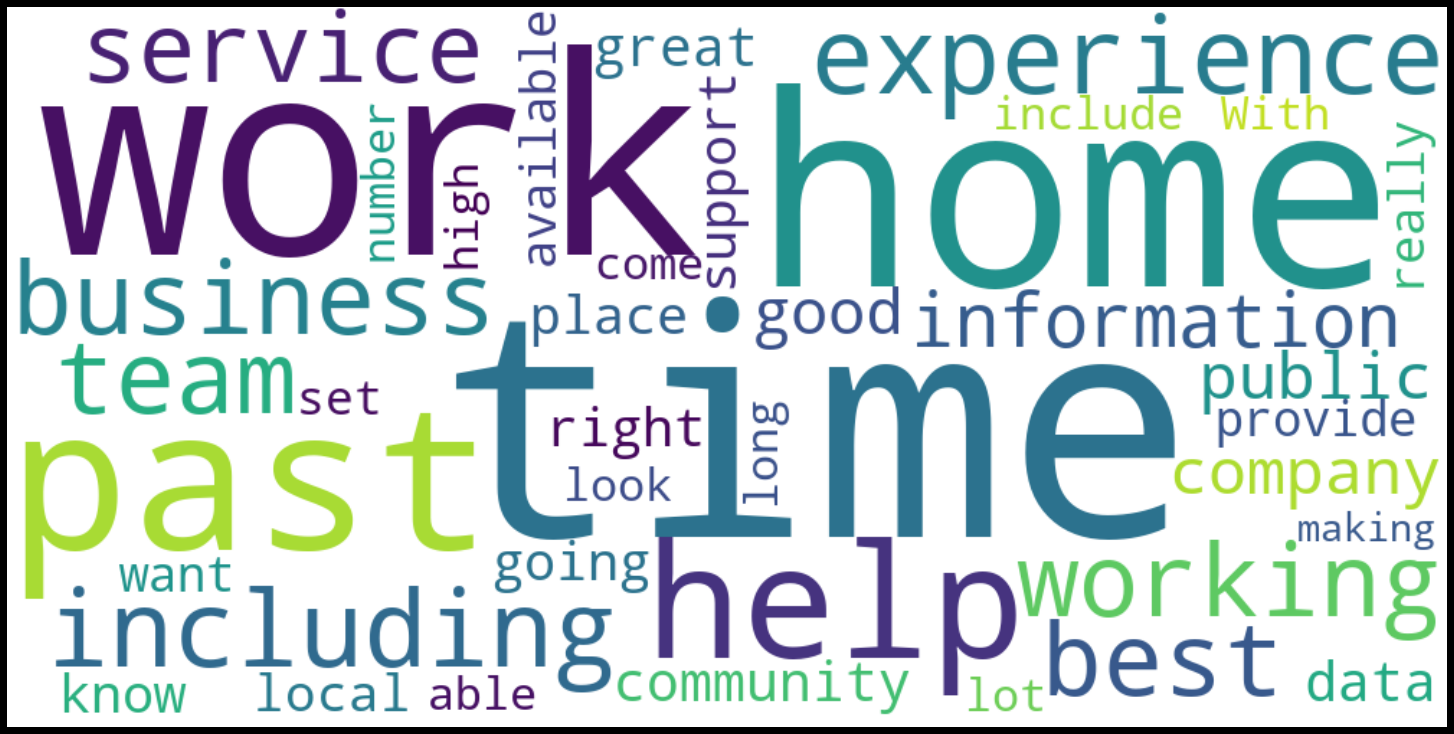

In [51]:
display_wordcloud(pos_vect_freq_fplt)

Analysis on speicific Topics

In [71]:
list_neg_topic = []
neg_dict = negative_tm.get_docs(topic_ids=[18], rank=True)
for x in neg_dict:
  list_neg_topic.append(x['text'])

In [78]:
#vect_freq = tfidf_vectordf(filter_topics_df)
neg_topic_vect_freq = tfidf_vectordf(list_neg_topic,lst=True)


Using TFIDF Vectorizer


In [81]:
neg_remove_label = ['said', 'Chicago','said','Pritzker','000','new','2020','In','This','just','says','We','according','Monday','He','like','10','It','000','week','use','Thursday','Tuesday','But','say','2021','2019',"Wednesday",'make','days','used','new','12','2018','20','If','They','people','And','By','20','dont','May','30','did','15','July','On','As','25','50','100','17','state','city','County','states','news','year']
neg_topic_vect_freq_fplt = neg_topic_vect_freq.drop(labels=neg_remove_label)

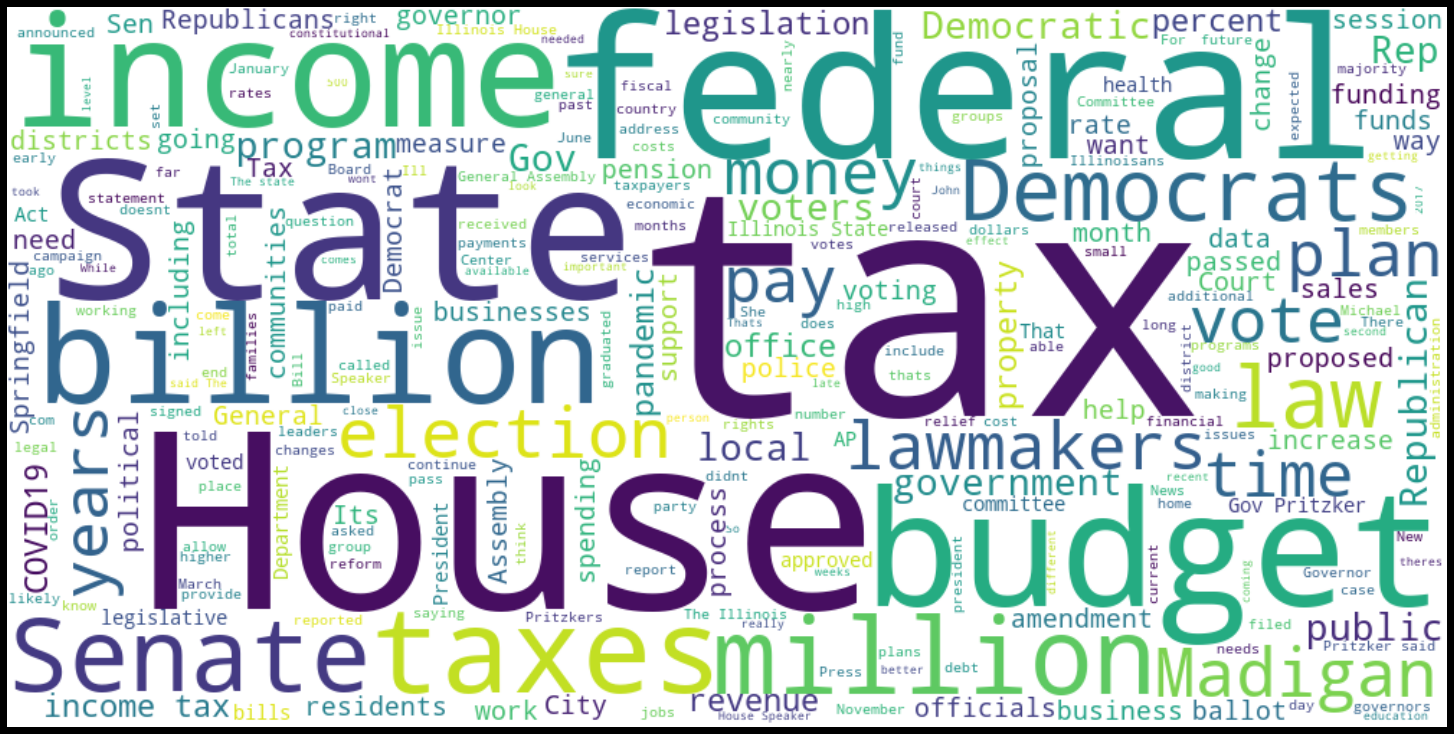

In [82]:
display_wordcloud(neg_topic_vect_freq_fplt)

Tax , income ,business in negative sentiment

In [87]:
filter_topics_df.columns

Index(['index', 'Unnamed: 0', 'date', 'language', 'title', 'text', 'text_clean', 'title_clean', 'rake_phrases', 'Top_Topic_Assigned', 'Perc_Contribution', 'Topic_Keywords', 'neg_prob', 'pos_prob', 'sentiment'], dtype='object')

In [93]:
exodus_relevant_df = filter_topics_df[filter_topics_df['text'].str.contains('exodus', case=False, na=False)]
exodus_relevant_df.head()

index  Unnamed: 0       date language                                                                                                                           title                                                                                                                                                                                                     text                                                                                                                                                                                               text_clean                                                                                                                    title_clean                                                                                                                                                                                             rake_phrases  Top_Topic_Assigned  Perc_Contribution  \
146    5381        5381 2019-10-18  english                                   Chicago Mayor Lightfoot tries to fill a budget gap and settle a teacher strike simultaneously  Some weeks are just doozies, for everyday citizens or for a Chicago mayor: Multiple deadlines land, an unexpected crisis hits. For you, it’s a work project and a broken refrigerator. For Mayor Lor...  Some weeks are just doozies, for everyday citizens or for a Chicago mayor: Multiple deadlines land, an unexpected crisis hits. For you, its a work project and a broken refrigerator. For Mayor Lori...                                  Chicago Mayor Lightfoot tries to fill a budget gap and settle a teacher strike simultaneously  whatever deal chicago public schools eventually reaches, another historically large property tax increase, illinois lawmakers invite scandals oct 18, electric truck upstart oct 18, graduated real ...                  78             0.7213   
435   15526       15526 2021-04-05  english                                                                Chicago exodus to suburbs in full swing, real estate broker says  Chicago exodus to suburbs in full swing, real estate broker says By Talia Kaplan Email Chicago-area housing market soars with high demand\nAyoub Rabah, president of Coldwell Banker, talks about th...  Chicago exodus to suburbs in full swing, real estate broker says By Talia Kaplan Email Chicagoarea housing market soars with high demandAyoub Rabah, president of Coldwell Banker, talks about the s...                                                               Chicago exodus to suburbs in full swing, real estate broker says  national median home sale price soared 17 yearoveryear, many americans working remotely seek larger spaces, sp corelogic caseshiller national home price index, talia kaplan email chicagoarea housi...                  78             0.3036   
1610  52661       52661 2019-10-21  english                                                                     Affordable housing among striking Chicago teachers' demands  Affordable housing among striking Chicago teachers' demands Kathleen Foody And Don Babwin, The Associated Press Monday Oct 21, 2019 at 5:36 PM Oct 21, 2019 at 5:37 PM\nCHICAGO (AP) " Striking Chic...  Affordable housing among striking Chicago teachers demands Kathleen Foody And Don Babwin, The Associated Press Monday Oct 21, 2019 at 5:36 PM Oct 21, 2019 at 5:37 PMCHICAGO AP  Striking Chicago te...                                                                     Affordable housing among striking Chicago teachers demands  monday also flatly rejected mayor lori lightfoots request, affordable housing among striking chicago teachers demands kathleen foody, 37 pmchicago ap striking chicago teachers, california school d...                  78             0.2608   
2189  70172       70172 2020-08-31  english                                                                          Looting, Riots Prompt Mass Exodus of Chicago Residents  While mayor Lori Lightfoot continues to try and assure th

In [94]:
exodus_vect_freq = tfidf_vectordf(exodus_relevant_df)

Using TFIDF Vectorizer


In [98]:
exodus_remove_label = ['said', 'said','Pritzker','000','new','2020','In','This','just','says','We','according','Monday','He','like','10','It','000','week','use','Thursday','Tuesday','But','say','2021','2019',"Wednesday",'make','days','used','new','12','2018','20','If','They','people','And','By','20','dont','May','30','did','15','July','On','As','25','50','17','state','city','County','states','news','year']
exodus_vect_freq_fplt = exodus_vect_freq.drop(labels=exodus_remove_label)

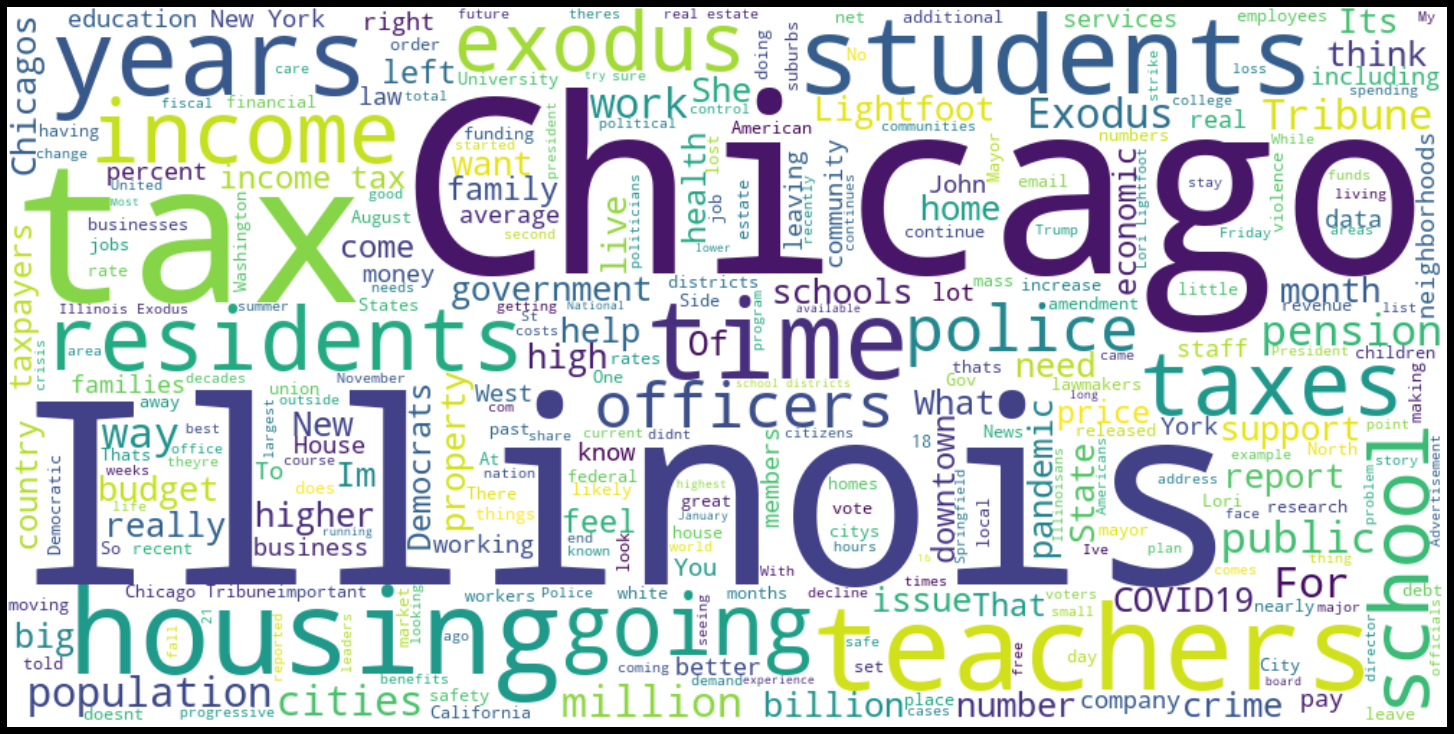

In [99]:
display_wordcloud(exodus_vect_freq_fplt)